In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import Counter

cudnn.benchmark = True
plt.ion()   # interactive mode

In [19]:
# Data augmentation and normalization for training
# Just normalization for validation
# and resize all image to shape (3,224,224)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Create Train,Val and test datasets
data_dir = 'https://drive.google.com/drive/folders/1jJ7TTKbpxXbXJEhy4mJ32Dd0G9W6JAfa?usp=share_link'
train_valid_data = datasets.ImageFolder('/content/drive/MyDrive/AIP/Assignment_1/classification_dataset/train',data_transforms['train'])

# Construct train and validation sets
train_data,valid_data = random_split(train_valid_data,[0.85,0.15], generator=torch.Generator().manual_seed(42))
test_data = datasets.ImageFolder('/content/drive/MyDrive/AIP/Assignment_1/classification_dataset/test',data_transforms['test'])

In [20]:
# Each class frequecies of Train_data 
Counter(train_valid_data.targets)

Counter({0: 82, 1: 92, 2: 90, 3: 90, 4: 67, 5: 111})

In [21]:
print(f'Train_data class freq - {Counter([label for _, label in train_data])}')
print(f'Valid_data class freq - {Counter([label for _, label in valid_data])}')
print(f'Test_data class freq - {Counter(test_data.targets)}')

Train_data class freq - Counter({5: 97, 1: 78, 3: 77, 2: 74, 0: 70, 4: 57})
Valid_data class freq - Counter({2: 16, 1: 14, 5: 14, 3: 13, 0: 12, 4: 10})
Test_data class freq - Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20})


In [22]:

# Create dataloaders for train,val and test set
image_datasets = {'train' : train_data, 'val' : valid_data, 'test' : test_data}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = train_valid_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cpu')

In [23]:
dataset_sizes

{'train': 453, 'val': 79, 'test': 120}

In [24]:
class_names

['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']

In [26]:
# Hyperparameters
num_classes = len(class_names)
learning_rate = 0.1
batch_size = 128
epochs = 10

In [27]:
# Load pre_trained resnet18 model with weights
model_conv = torchvision.models.resnet18(pretrained=True)

# Disable gradient update for all weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

# Change last layer size to num_classes
model_conv.fc = nn.Linear(num_ftrs, num_classes)

# Load device to cuda
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # keeps track of best_model for every epoch that performs better on val dataset
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Keep track of losses and accuracy in each epoch
    losses = {'train':[],'val':[]}
    acc = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,losses,acc

In [29]:
model_ft,loss,acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/9
----------
train Loss: 2.7524 Acc: 0.3201
val Loss: 2.2821 Acc: 0.5570

Epoch 1/9
----------
train Loss: 2.2957 Acc: 0.6424
val Loss: 0.7424 Acc: 0.7975

Epoch 2/9
----------
train Loss: 1.2169 Acc: 0.8278
val Loss: 0.6811 Acc: 0.8861

Epoch 3/9
----------
train Loss: 0.5851 Acc: 0.8874
val Loss: 1.0607 Acc: 0.7975

Epoch 4/9
----------
train Loss: 0.4962 Acc: 0.9183
val Loss: 0.9694 Acc: 0.8608

Epoch 5/9
----------
train Loss: 0.5123 Acc: 0.9117
val Loss: 1.4426 Acc: 0.8481

Epoch 6/9
----------
train Loss: 0.5109 Acc: 0.9117
val Loss: 1.0032 Acc: 0.8734

Epoch 7/9
----------
train Loss: 0.5046 Acc: 0.9205
val Loss: 1.0945 Acc: 0.8481

Epoch 8/9
----------
train Loss: 0.3057 Acc: 0.9404
val Loss: 0.7982 Acc: 0.8608

Epoch 9/9
----------
train Loss: 0.4134 Acc: 0.9338
val Loss: 0.7274 Acc: 0.8987

Training complete in 7m 56s
Best val Acc: 0.898734


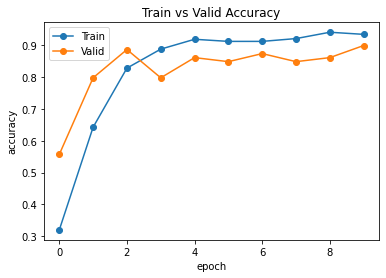

In [30]:
plt.plot(torch.tensor(acc['train']).numpy(),'-o')
plt.plot(torch.tensor(acc['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

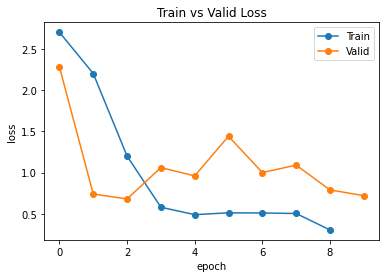

In [7]:
plt.plot(torch.tensor(loss['train']).numpy(),'-o')
plt.plot(torch.tensor(loss['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

In [38]:
def test_model(model, criterion):
    since = time.time()
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    y_test = np.empty((0,1))
    pred = np.empty((0,1))

    with torch.no_grad():
      for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
            
            # calculate the loss
        loss = criterion(outputs, labels)
            
            # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        y_test = np.append(y_test,torch.Tensor.cpu(labels).numpy().reshape(-1,1),axis = 0)
        pred = np.append(pred,torch.Tensor.cpu(preds).numpy().reshape(-1,1),axis = 0)
              
                # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    total_loss = running_loss / dataset_sizes['test']
    total_acc = running_corrects.double() / dataset_sizes['test']

    print()

    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Loss: {total_loss:.4f} Acc: {total_acc:.4f}')
    return y_test,pred

In [39]:
y_test,pred = test_model(model_ft, criterion)


Testing complete in 0m 11s
Loss: 0.0071 Acc: 1.0000


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, target_names=class_names))

              precision    recall  f1-score   support

        bear       1.00      1.00      1.00        20
   butterfly       1.00      1.00      1.00        20
       camel       1.00      1.00      1.00        20
       chimp       1.00      1.00      1.00        20
        duck       1.00      1.00      1.00        20
    elephant       1.00      1.00      1.00        20

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

